In [1]:
# import
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from orakl.attr import RandomSamplingPool
from orakl.attr import ExpectedModelChange

sns.set()
tf.random.set_seed(1024)
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.0.0
Eager execution: True


In [2]:
# download dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

x_train_pool = x_train[100:]
y_train_pool = y_train[100:]

def create_mnist_dataset(data, labels, batch_size):
  def gen():
    for image, label in zip(data, labels):
        yield image, label
  ds = tf.data.Dataset.from_generator(gen, (tf.float32, tf.int32), ((28,28 ), ()))

  return ds.batch(batch_size)

#train and validation dataset with different batch size
train_dataset = create_mnist_dataset(x_train[:100], y_train[:100], 10)
valid_dataset = create_mnist_dataset(x_test[:500], y_test[:500], 32)

print(train_dataset)
print(valid_dataset)

<DatasetV1Adapter shapes: ((None, 28, 28), (None,)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((None, 28, 28), (None,)), types: (tf.float32, tf.int32)>


In [3]:
def make_model():
  initializer = tf.initializers.he_normal(seed=0)
  model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,
                          activation=tf.nn.relu,
                          input_shape=(28*28,),
                          kernel_initializer=initializer,
                          bias_initializer=initializer),  # input shape required
    tf.keras.layers.Dense(32,
                          activation=tf.nn.relu,
                          kernel_initializer=initializer,
                          bias_initializer=initializer),
    tf.keras.layers.Dense(10,
                          kernel_initializer=initializer,
                          bias_initializer=initializer)
  ])

  return model

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y):
  y_ = model(x)

  return loss_object(y_true=y, y_pred=y_)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [4]:
def train_loop(model, train_dataset):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for i, (x, y) in enumerate(train_dataset):
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        epoch_accuracy(y, model(x))

    return epoch_loss_avg, epoch_accuracy

def val_loop(model, valid_dataset):
    valid_accuracy = tf.keras.metrics.Accuracy()
    for (x, y) in valid_dataset:
        logits = model(x)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        valid_accuracy(prediction, y)

    return valid_accuracy

In [14]:
def train(train_dataset, valid_dataset, sampling_strategy=None, n_samples=2):
  model = make_model()

  valid_accuracy_results = []
  num_epochs = 51
  excluded_indexes = []

  # training loop
  for epoch in range(num_epochs):
    epoch_loss_avg, epoch_accuracy = train_loop(model, train_dataset)

    if epoch % 10 == 0:
      # print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
      #                                                             epoch_loss_avg.result(),
      #                                                             epoch_accuracy.result()))

      # validation loop                                                            
      valid_accuracy = val_loop(model, valid_dataset)
      # print("Valid set accuracy: {:.3%}".format(valid_accuracy.result()))
      valid_accuracy_results.append(valid_accuracy.result())

      if sampling_strategy is not None:
        indexes, samples = sampling_strategy(model,
                                             data_pool=x_train_pool[:100],
                                             n_samples=n_samples,
                                             excluded_indexes=excluded_indexes,
                                             batch_size=20)

        additional_dataset = create_mnist_dataset(x_train_pool[indexes], y_train_pool[indexes], 10)
        train_dataset = train_dataset.concatenate(additional_dataset)
      
  return valid_accuracy_results

In [15]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE)

naive_results = train(train_dataset, valid_dataset, sampling_strategy=None)
random_results = train(train_dataset, valid_dataset, sampling_strategy=RandomSamplingPool())
emc_results = train(train_dataset, valid_dataset, sampling_strategy=ExpectedModelChange(loss_function=loss_function, n_classes=10,))

0%|          | 0/5 [00:00<?, ?it/s]W1212 09:37:44.620639 4432612800 base_layer.py:1814] Layer sequential_6 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


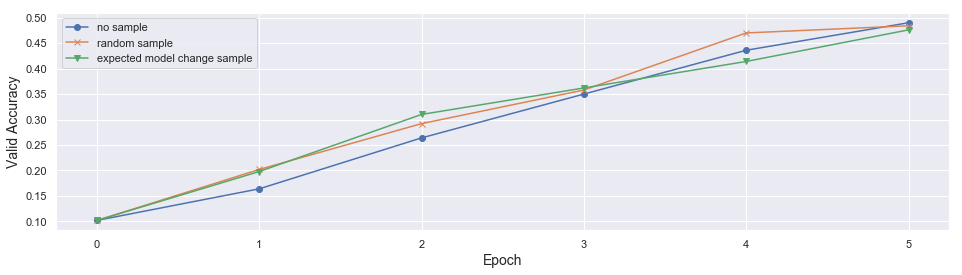

In [16]:
fig, axes = plt.subplots(1, sharex=True, figsize=(16, 4))

axes.set_ylabel("Valid Accuracy", fontsize=14)
axes.set_xlabel("Epoch", fontsize=14)
axes.plot(naive_results, marker="o", label="no sample")
axes.plot(random_results, marker="x", label="random sample")
axes.plot(emc_results, marker="v", label="expected model change sample")
axes.legend()
plt.show()

tf.Tensor([5 0 4 1 9 2 1 3 1 4], shape=(10,), dtype=int32)
